In [17]:
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.dates as mdates
import xgboost as xgb

from tqdm import tqdm
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from datetime import datetime, timedelta

In [18]:
billboard_hot_100 = pd.read_csv("../billboard_hot_100.csv")

In [19]:
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)

billboard_hot_100["last_week_position"] = pd.to_numeric(billboard_hot_100["last_week_position"], errors="coerce",
                                                        downcast="integer")

billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year

In [20]:
grouped = billboard_hot_100.sort_values(["artist", "song_name", "first_day_of_the_week"]).groupby(["artist", "song_name"])
rows_to_add = []
for name, group in grouped:
    max_week = group["first_day_of_the_week"].max()
    previous_row = None

    for row_index, row in group.iterrows():
        if previous_row is not None:
            rows_to_add.append({
                "artist": previous_row["artist"],
                "song_name": previous_row["song_name"],
                "first_day_of_the_week": previous_row["first_day_of_the_week"],
                "position": previous_row["position"],
                "last_week_position": previous_row["last_week_position"],
                "next_position": row["position"],
                "weeks_on_chart": previous_row["weeks_on_chart"],
                "peak_position": previous_row["peak_position"]
            })
        if row["first_day_of_the_week"] == max_week:
            rows_to_add.append({
                "artist": row["artist"],
                "song_name": row["song_name"],
                "first_day_of_the_week": row["first_day_of_the_week"],
                "position": row["position"],
                "last_week_position": row["last_week_position"],
                "next_position": 101,
                "weeks_on_chart": row["weeks_on_chart"],
                "peak_position": row["peak_position"]
            })

        previous_row = row

billboard_hot_100 = pd.DataFrame.from_records(rows_to_add)

In [21]:
billboard_hot_100

,artist,song_name,first_day_of_the_week,position,last_week_position,next_position,weeks_on_chart,peak_position
0,"""Groove"" Holmes",Misty,1966-06-20,100,NaN,85,1,100
1,"""Groove"" Holmes",Misty,1966-06-27,85,100.0,84,2,85
2,"""Groove"" Holmes",Misty,1966-07-04,84,85.0,82,3,84
3,"""Groove"" Holmes",Misty,1966-07-11,82,84.0,64,4,82
4,"""Groove"" Holmes",Misty,1966-07-18,64,82.0,50,5,64
...,...,...,...,...,...,...,...,...
336082,will.i.am Featuring Mick Jagger & Jennifer Lopez,T.H.E (The Hardest Ever),2012-02-06,61,73.0,86,7,36
336083,will.i.am Featuring Mick Jagger & Jennifer Lopez,T.H.E (The Hardest Ever),2012-02-13,86,61.0,101,8,36
336084,will.i.am Featuring Miley Cyrus,Fall Down,2013-04-29,58,NaN,101,1,58
336085,"will.i.am Featuring Miley Cyrus, French Montan...",Feelin' Myself,2014-04-21,96,NaN,99,1,96


In [22]:
billboard_hot_100.columns

Index(['artist', 'song_name', 'first_day_of_the_week', 'position',
       'last_week_position', 'next_position', 'weeks_on_chart',
       'peak_position'],
      dtype='object')

In [23]:
feature_columns = ["first_day_of_the_week", "last_week_position", "peak_position", "weeks_on_chart", "position"]
X = billboard_hot_100[feature_columns].copy()
y = billboard_hot_100["next_position"].copy()

In [24]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

label_encoder.fit(X["first_day_of_the_week"])
X["first_day_of_the_week"] = label_encoder.transform(X["first_day_of_the_week"])

In [25]:
position_encoder = LabelEncoder()

position_encoder.fit(y)
y = position_encoder.transform(y)

In [26]:
X["last_week_position"] = X['last_week_position'].fillna(101)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

In [30]:
clf = DecisionTreeClassifier()

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [31]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.1227746536146072


In [32]:
# https://www.entechin.com/find-nearest-value-list-python/
def closest_value(input_set, input_value):
  arr = list(input_set)
  i = (np.abs(arr - input_value)).argmin()
 
  return arr[i]

In [33]:
new_data = []
new_data.append([])

song_id = 1

all_weeks = billboard_hot_100["first_day_of_the_week"].drop_duplicates().sort_values().to_list()

for i in range(1, 101):
    new_row = {"position": i, "last_week_position": np.nan, "peak_position": i, "weeks_on_chart": 1, "year": 1958, "first_day_of_the_week": all_weeks[0],
               "song_id": song_id}
    song_id += 1
    new_row = pd.DataFrame(new_row, index=[0])
    new_data[-1].append(new_row)

all_positions = range(1, 101)

for week in tqdm(all_weeks[1:]):
    year = week.year
    new_data.append([])

    positions_in_week = []
    data_copy = pd.concat(new_data[-2])
    data_copy["first_day_of_the_week"] = label_encoder.transform(data_copy["first_day_of_the_week"])
    positions = position_encoder.inverse_transform(clf.predict(data_copy[feature_columns].fillna(101)))
    missing_positions = set(all_positions) - set(positions)
    for position, (row_index, row) in zip(positions, data_copy.iterrows()):
        if position != 101 and position not in positions_in_week:
            new_row = {"position": position, "last_week_position": row["position"], "peak_position": np.min([row["position"], position]), "weeks_on_chart": row["weeks_on_chart"] + 1, "year": year, "first_day_of_the_week": week,
                       "song_id": row["song_id"]}
            positions_in_week.append(position)
            new_row = pd.DataFrame(new_row, index=[0])
            new_data[-1].append(new_row)
        # elif position != 101 and position in positions_in_week:
        #     new_position = closest_value(missing_positions, position)
        #     if np.abs(position - new_position) < 10:
        #         missing_positions.remove(new_position)
        #         new_row = {"position": new_position, "last_week_position": row["position"], "peak_position": np.min([row["position"], new_position]), "weeks_on_chart": row["weeks_on_chart"] + 1, "year": year, "first_day_of_the_week": week,
        #                 "song_id": row["song_id"]}
        #         positions_in_week.append(new_position)
        #         new_row = pd.DataFrame(new_row, index=[0])
        #         new_data[-1].append(new_row)

    missing_positions = set(all_positions) - set(positions_in_week)
    for i in missing_positions:
        new_row = {"position": i, "last_week_position": np.nan, "peak_position": i, "weeks_on_chart": 1, "year": year, "first_day_of_the_week": week,
            "song_id": song_id}
        new_row = pd.DataFrame(new_row, index=[0])
        new_data[-1].append(new_row)
        song_id += 1

100%|██████████| 3360/3360 [12:01<00:00,  4.66it/s]


In [34]:
data_array = [item for sublist in new_data for item in sublist]

In [35]:
own_chart = pd.concat(data_array)

In [36]:
own_chart.to_csv("rules_based_chart.csv")

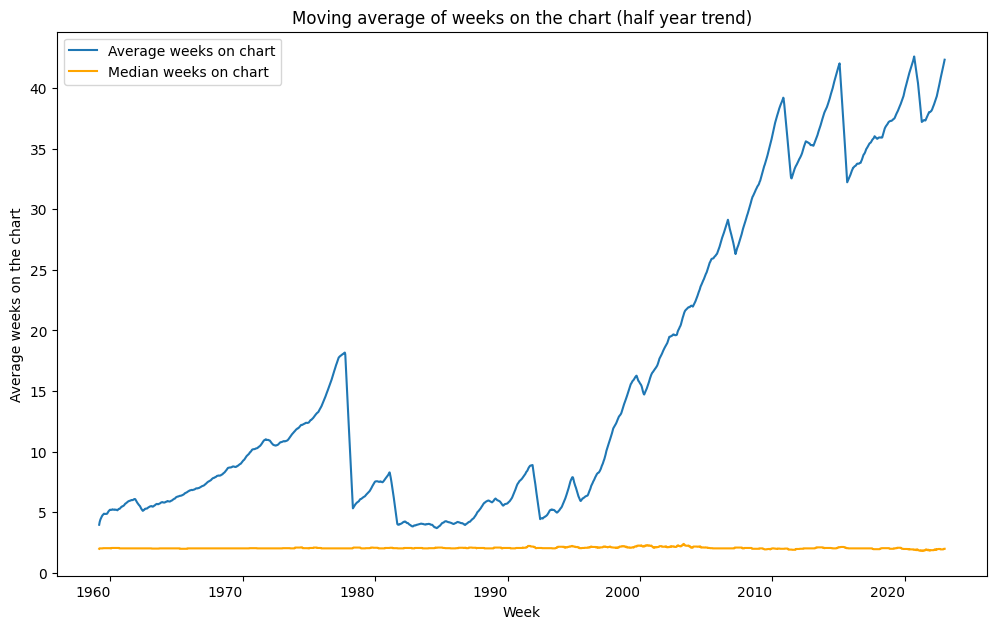

In [37]:
avg_weeks_on_chart = own_chart[["first_day_of_the_week", "weeks_on_chart"]].groupby(
    by="first_day_of_the_week").mean().rolling(window=30).mean()

median_weeks_on_chart = own_chart[["first_day_of_the_week", "weeks_on_chart"]].groupby(
    by="first_day_of_the_week").median().rolling(window=30).mean()

avg_weeks_on_chart_plot = avg_weeks_on_chart.plot(kind='line', figsize=(12, 8), legend=False, rot=0)
median_weeks_on_chart.plot(kind='line', figsize=(12, 8), legend=False, rot=0,
    ax=avg_weeks_on_chart_plot, color="orange")

# avg_weeks_on_chart_plot.axvline(x = spotify_creation_date, color = 'green')
# avg_weeks_on_chart_plot.axvline(x = youtube_creation_date, color = 'red')
# avg_weeks_on_chart_plot.axvline(x = apple_music_creation_date, color = 'pink')
# avg_weeks_on_chart_plot.axvline(x = mtv_launch_date, color = 'black')
# avg_weeks_on_chart_plot.axvline(x = cds_creation_date, color = 'turquoise')
# avg_weeks_on_chart_plot.axvline(x = mp3_creation_date, color = 'yellow')

plt.title("Moving average of weeks on the chart (half year trend)")
plt.xlabel("Week")
plt.ylabel("Average weeks on the chart")
plt.legend(["Average weeks on chart", "Median weeks on chart"])

#plt.savefig("figures/average_weeks_on_chart.pdf", format="pdf")#, bbox_inches="tight")
plt.show()

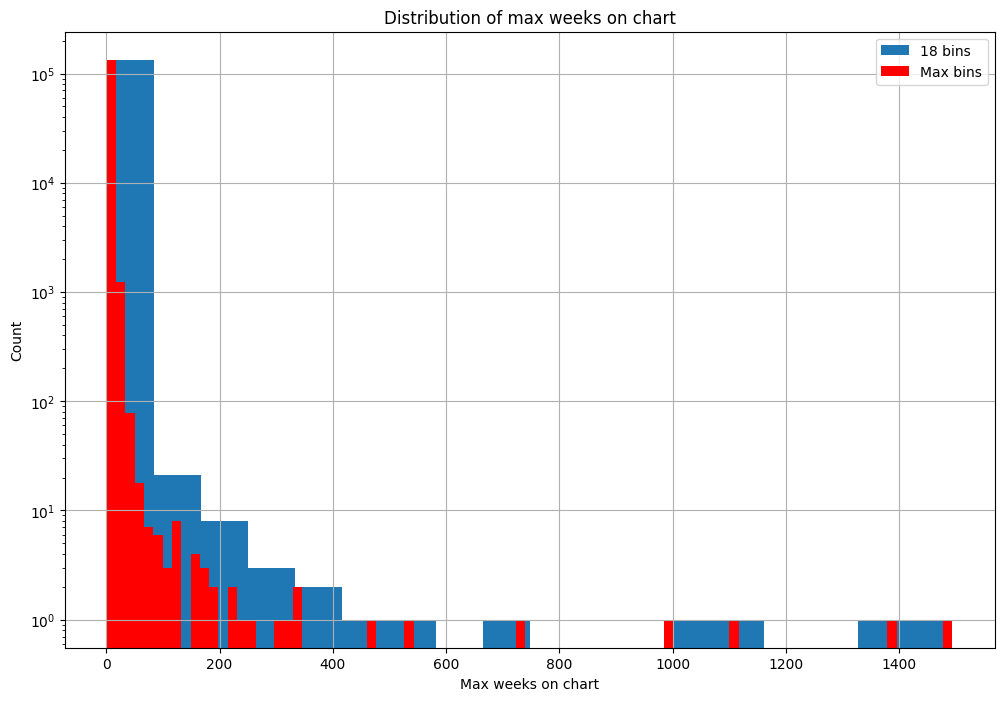

In [38]:
max_weeks_on_chart = own_chart[["song_id", "weeks_on_chart"]].groupby(
    by=["song_id"]).max().reset_index()
max_weeks_on_chart = max_weeks_on_chart.set_index("song_id")

max_weeks_on_chart_ax = max_weeks_on_chart.hist(bins=18, figsize=(12, 8), legend=False)
max_weeks_on_chart.hist(bins=billboard_hot_100["weeks_on_chart"].max(), figsize=(12, 8), legend=False, color="red", ax=max_weeks_on_chart_ax)

plt.title("Distribution of max weeks on chart")
plt.xlabel("Max weeks on chart")
plt.ylabel("Count")
plt.legend(["18 bins", "Max bins"])
plt.yscale("log")

#plt.savefig("figures/max_weeks_on_chart_distribution.pdf", format="pdf")
plt.show()

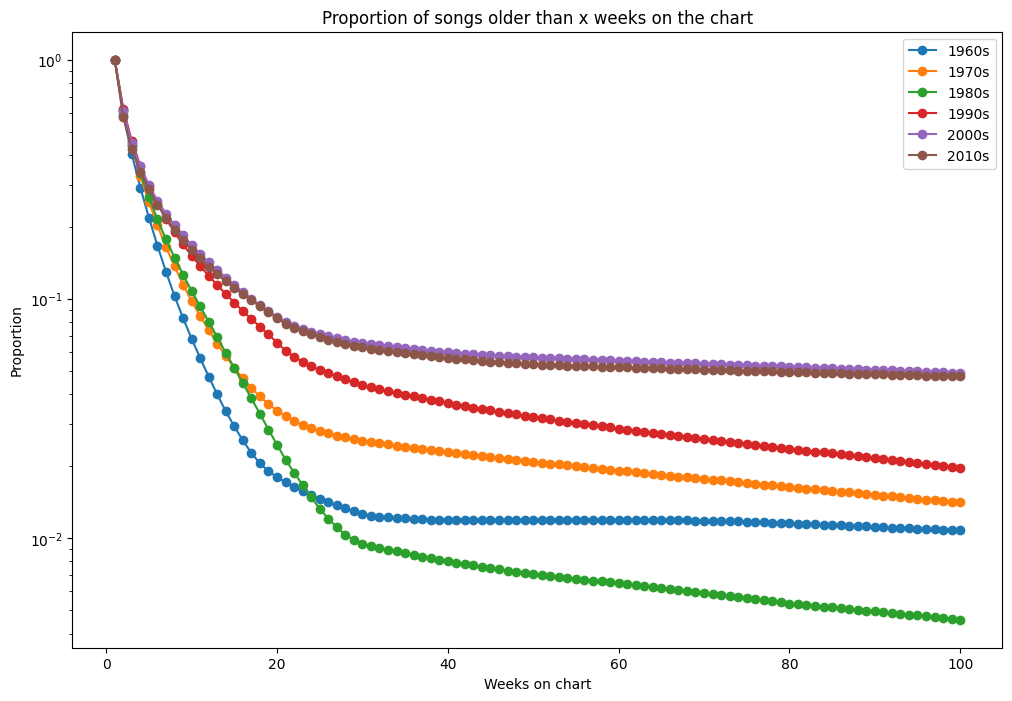

In [39]:
plt.figure(figsize=(12, 8))

for year in range(1960, 2020, 10):
    proportion_of_songs_older_than_x_weeks = []
    for i in range(1, 101):
        proportion_of_songs_older_than_x_weeks.append(
            own_chart[(own_chart["weeks_on_chart"] >= i) & (own_chart["year"] >= year) &\
                 (own_chart["year"] < year + 10)].shape[0] / own_chart[(own_chart["year"] >= year) &\
                 (own_chart["year"] < year + 10)].shape[0])
    plt.plot(range(1, 101), proportion_of_songs_older_than_x_weeks, marker='o', label=f"{year}s")

plt.title("Proportion of songs older than x weeks on the chart")
plt.xlabel("Weeks on chart")
plt.ylabel("Proportion")
plt.legend()
plt.yscale("log")
plt.show()

In [40]:
grouped = own_chart.groupby(["song_id"])
rows_to_add = []
for name, group in grouped:
    max_week = group["first_day_of_the_week"].max()
    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            rows_to_add.append({
                "song_id": row["song_id"],
                "first_day_of_the_week": row["first_day_of_the_week"] + timedelta(weeks=1),
                "position": 101,
                "last_week_position": row["position"],
                "peak_position": row["peak_position"],
                "weeks_on_chart": row["weeks_on_chart"],
                "year": row["year"]
            })

own_chart_with_disappeared_songs = pd.concat([billboard_hot_100, pd.DataFrame.from_records(rows_to_add)], ignore_index=True)

C:\Users\cutie\AppData\Local\Temp\ipykernel_18688\2837561770.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:


In [41]:
def calculate_position_difference(position, last_week_position):
    if np.isnan(last_week_position):
        return 100 - position
    return last_week_position - position

own_chart_with_disappeared_songs["position_change"] = own_chart_with_disappeared_songs.apply(
    lambda x: calculate_position_difference(x["position"], x["last_week_position"]), axis=1)

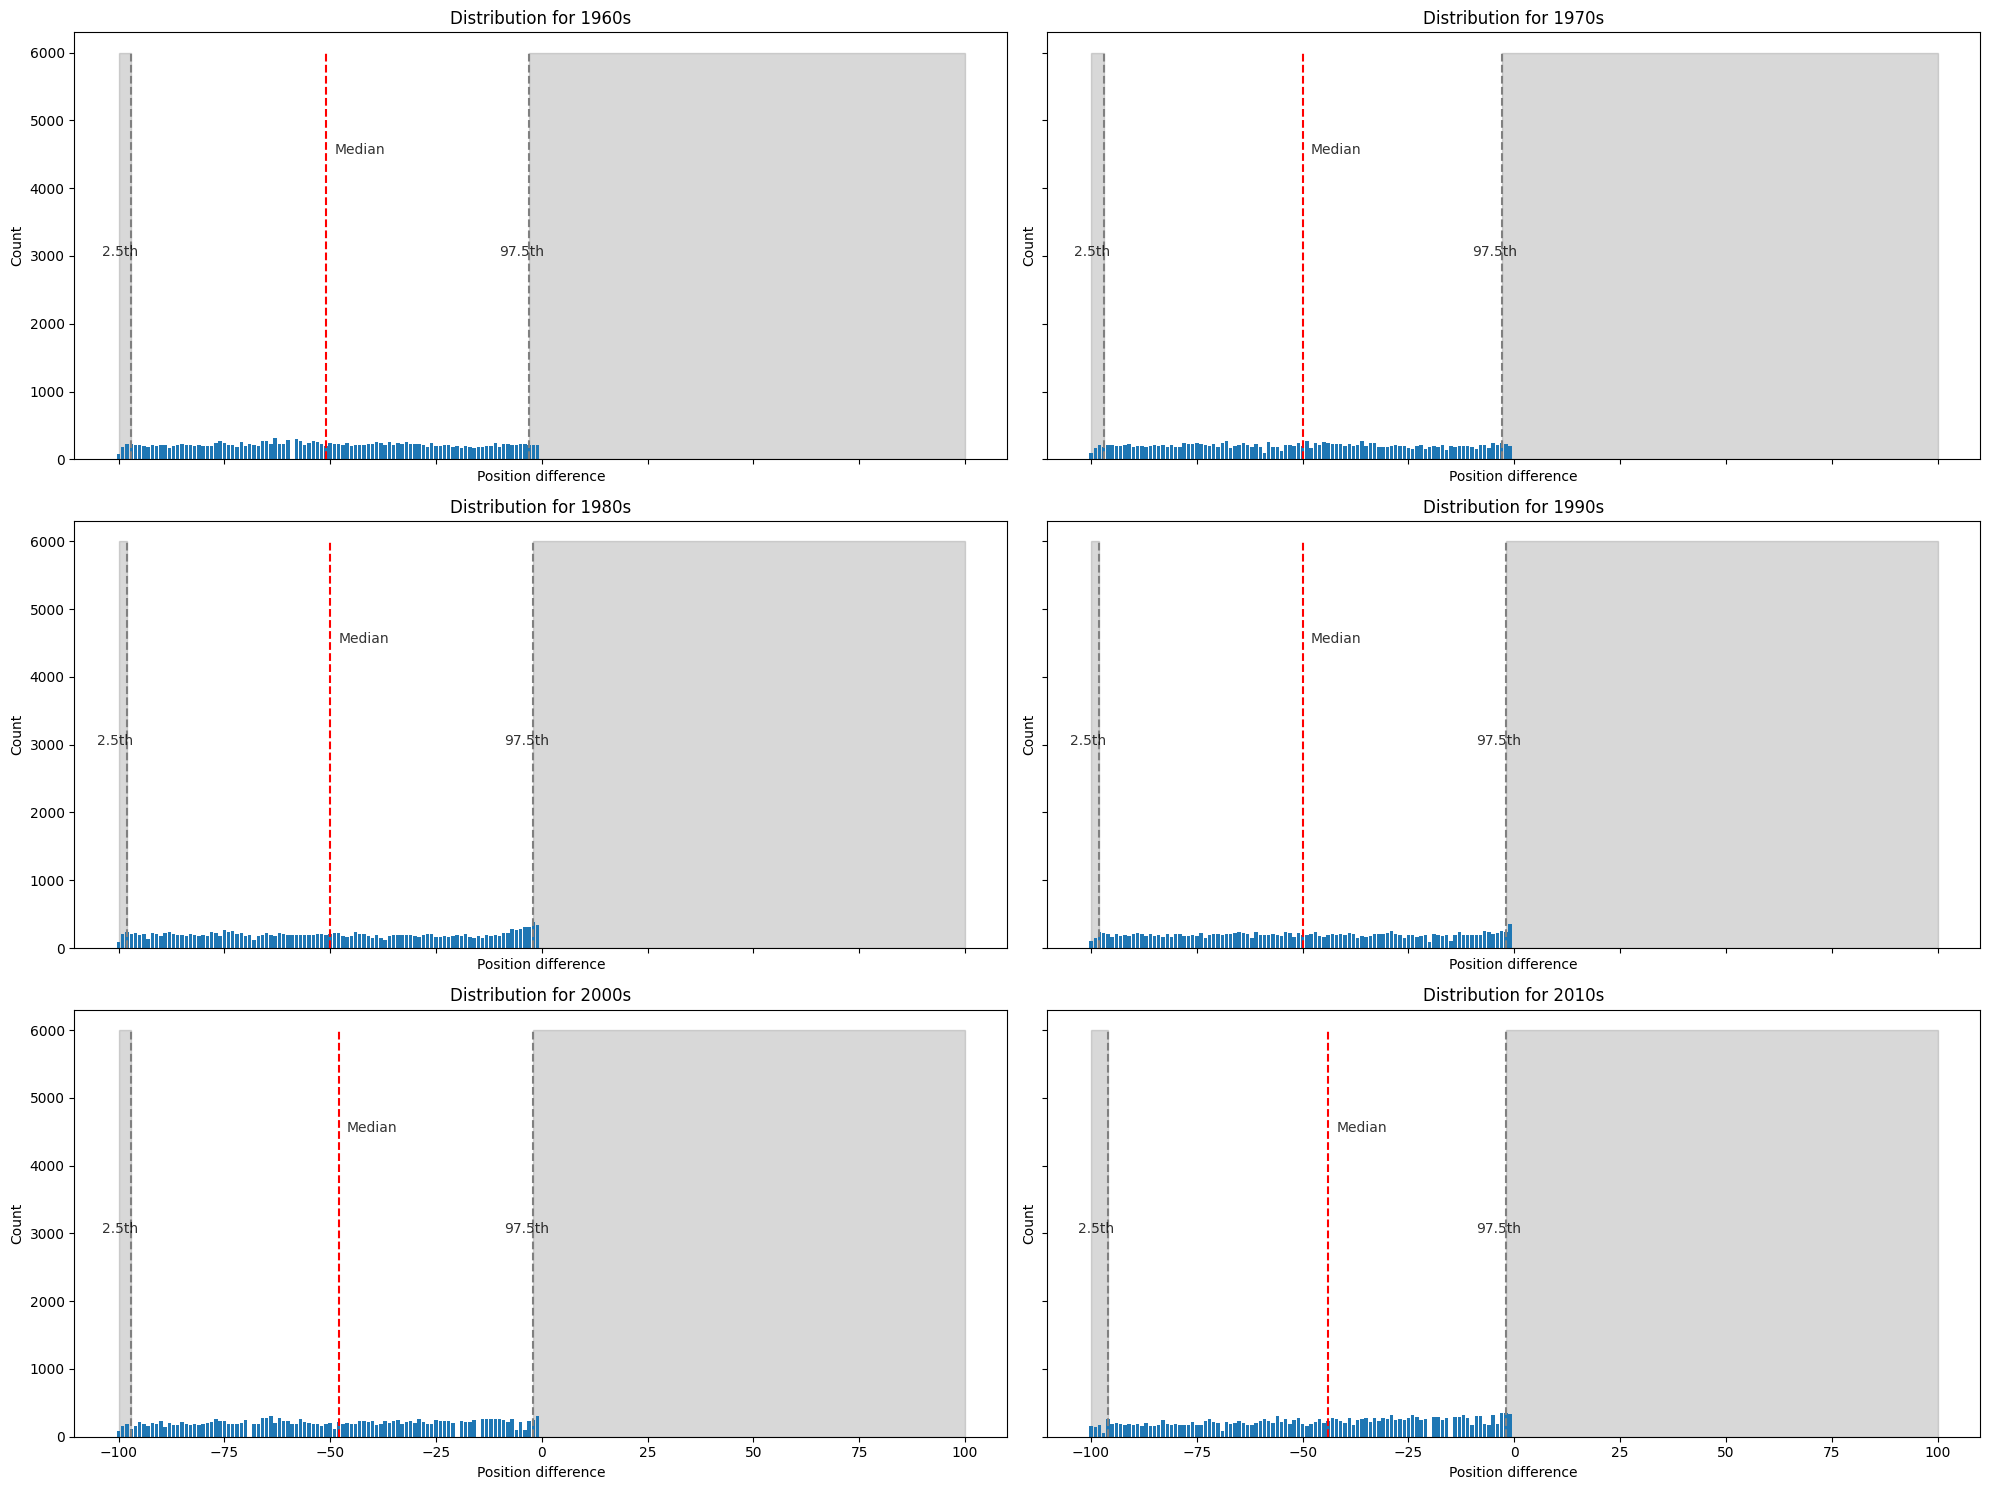

In [42]:
import matplotlib.patches as patches
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharex=True, sharey=True)

row = 0
col = 0

billboard_subset = own_chart_with_disappeared_songs[["year", "first_day_of_the_week", "position_change"]]

for year in range(1960, 2020, 10):
    decade_subset = billboard_subset[(billboard_subset["year"] >= year) &\
        (billboard_subset["year"] < year + 10)]["position_change"]
    count_changes = decade_subset.value_counts().sort_index()

    perecentile_25 = decade_subset.quantile(0.025)
    perecentile_975 = decade_subset.quantile(0.975)
    perecentile_50 = decade_subset.quantile(0.5)

    axes[row, col].vlines(perecentile_25, ymin=0, ymax=6000, color="grey", linestyle='--')
    axes[row, col].vlines(perecentile_975, ymin=0, ymax=6000, color="grey", linestyle='--')
    axes[row, col].vlines(perecentile_50, ymin=0, ymax=6000, color="red", linestyle='--')
    
    # mark the percentiles 
    rect_left = patches.Rectangle((-100, 0), 100 + perecentile_25, 6000, linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.3)
    axes[row, col].add_patch(rect_left)
    axes[row, col].text(perecentile_25 - 7, 3000, "2.5th", size = 10, alpha = 0.8)
    rect_right = patches.Rectangle((perecentile_975, 0), 100 - perecentile_975, 6000, linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.3)
    axes[row, col].add_patch(rect_right)
    axes[row, col].text(perecentile_975 - 7, 3000, "97.5th", size = 10, alpha = 0.8)

    axes[row, col].text(perecentile_50 + 2, 4500, "Median", size = 10, alpha = 0.8)

    axes[row, col].bar(count_changes.index, count_changes.values)
    axes[row, col].set_title(f"Distribution for {year}s")
    axes[row, col].set_xlabel("Position difference")
    axes[row, col].set_ylabel("Count")
    axes[row, col].xaxis.set_major_locator(plt.MaxNLocator(10))
    col += 1
    if col == 2:
        col = 0
        row += 1

plt.locator_params(axis='x', nbins=10)
fig.tight_layout()
plt.show()

In [43]:
own_chart["top_position"] = own_chart.groupby(
    ["song_id"])["position"].transform("min")

In [44]:
import dateutil.parser
rows_to_add = []

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = own_chart[(own_chart["year"] < year) |\
        (own_chart["year"] >= year + 10)][["song_id"]]
    
    songs_in_decade = own_chart[(own_chart["year"] >= year) &\
        (own_chart["year"] < year + 10) & ~(own_chart["song_id"].isin(songs_from_other_decades["song_id"]))][["song_id", "weeks_on_chart",
                "position", "first_day_of_the_week", "year", "top_position"]]
    grouped = songs_in_decade.groupby(["song_id"])

    min_first_week = songs_in_decade["first_day_of_the_week"].min().to_pydatetime()

    for name, group in grouped:
        max_week = group["first_day_of_the_week"].max().to_pydatetime()

        for row_index, row in group.iterrows():
            if row["first_day_of_the_week"] == max_week:
                week_date = row["first_day_of_the_week"] + timedelta(weeks=1)

                while week_date < dateutil.parser.parse(f"{year + 9}-12-31"):
                    rows_to_add.append({
                        "song_id": row["song_id"],
                        "weeks_on_chart": row["weeks_on_chart"],
                        "position": 101,
                        "first_day_of_the_week": week_date,
                        "year": week_date.year,
                        "top_position": row["top_position"]
                    })
                    week_date += timedelta(weeks=1)

own_chart_with_empty_weeks = pd.concat([own_chart[["song_id",
    "weeks_on_chart", "position", "first_day_of_the_week", "year", "top_position"]], pd.DataFrame(rows_to_add)], ignore_index=True)

C:\Users\cutie\AppData\Local\Temp\ipykernel_18688\3995549574.py:16: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:
C:\Users\cutie\AppData\Local\Temp\ipykernel_18688\3995549574.py:16: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:
C:\Users\cutie\AppData\Local\Temp\ipykernel_18688\3995549574.py:16: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:
C:\Users\cutie\AppData\Local\Temp\ipykernel_18688

In [45]:
own_chart_with_empty_weeks["first_week"] = own_chart_with_empty_weeks.groupby(["song_id"])["first_day_of_the_week"].transform("min")

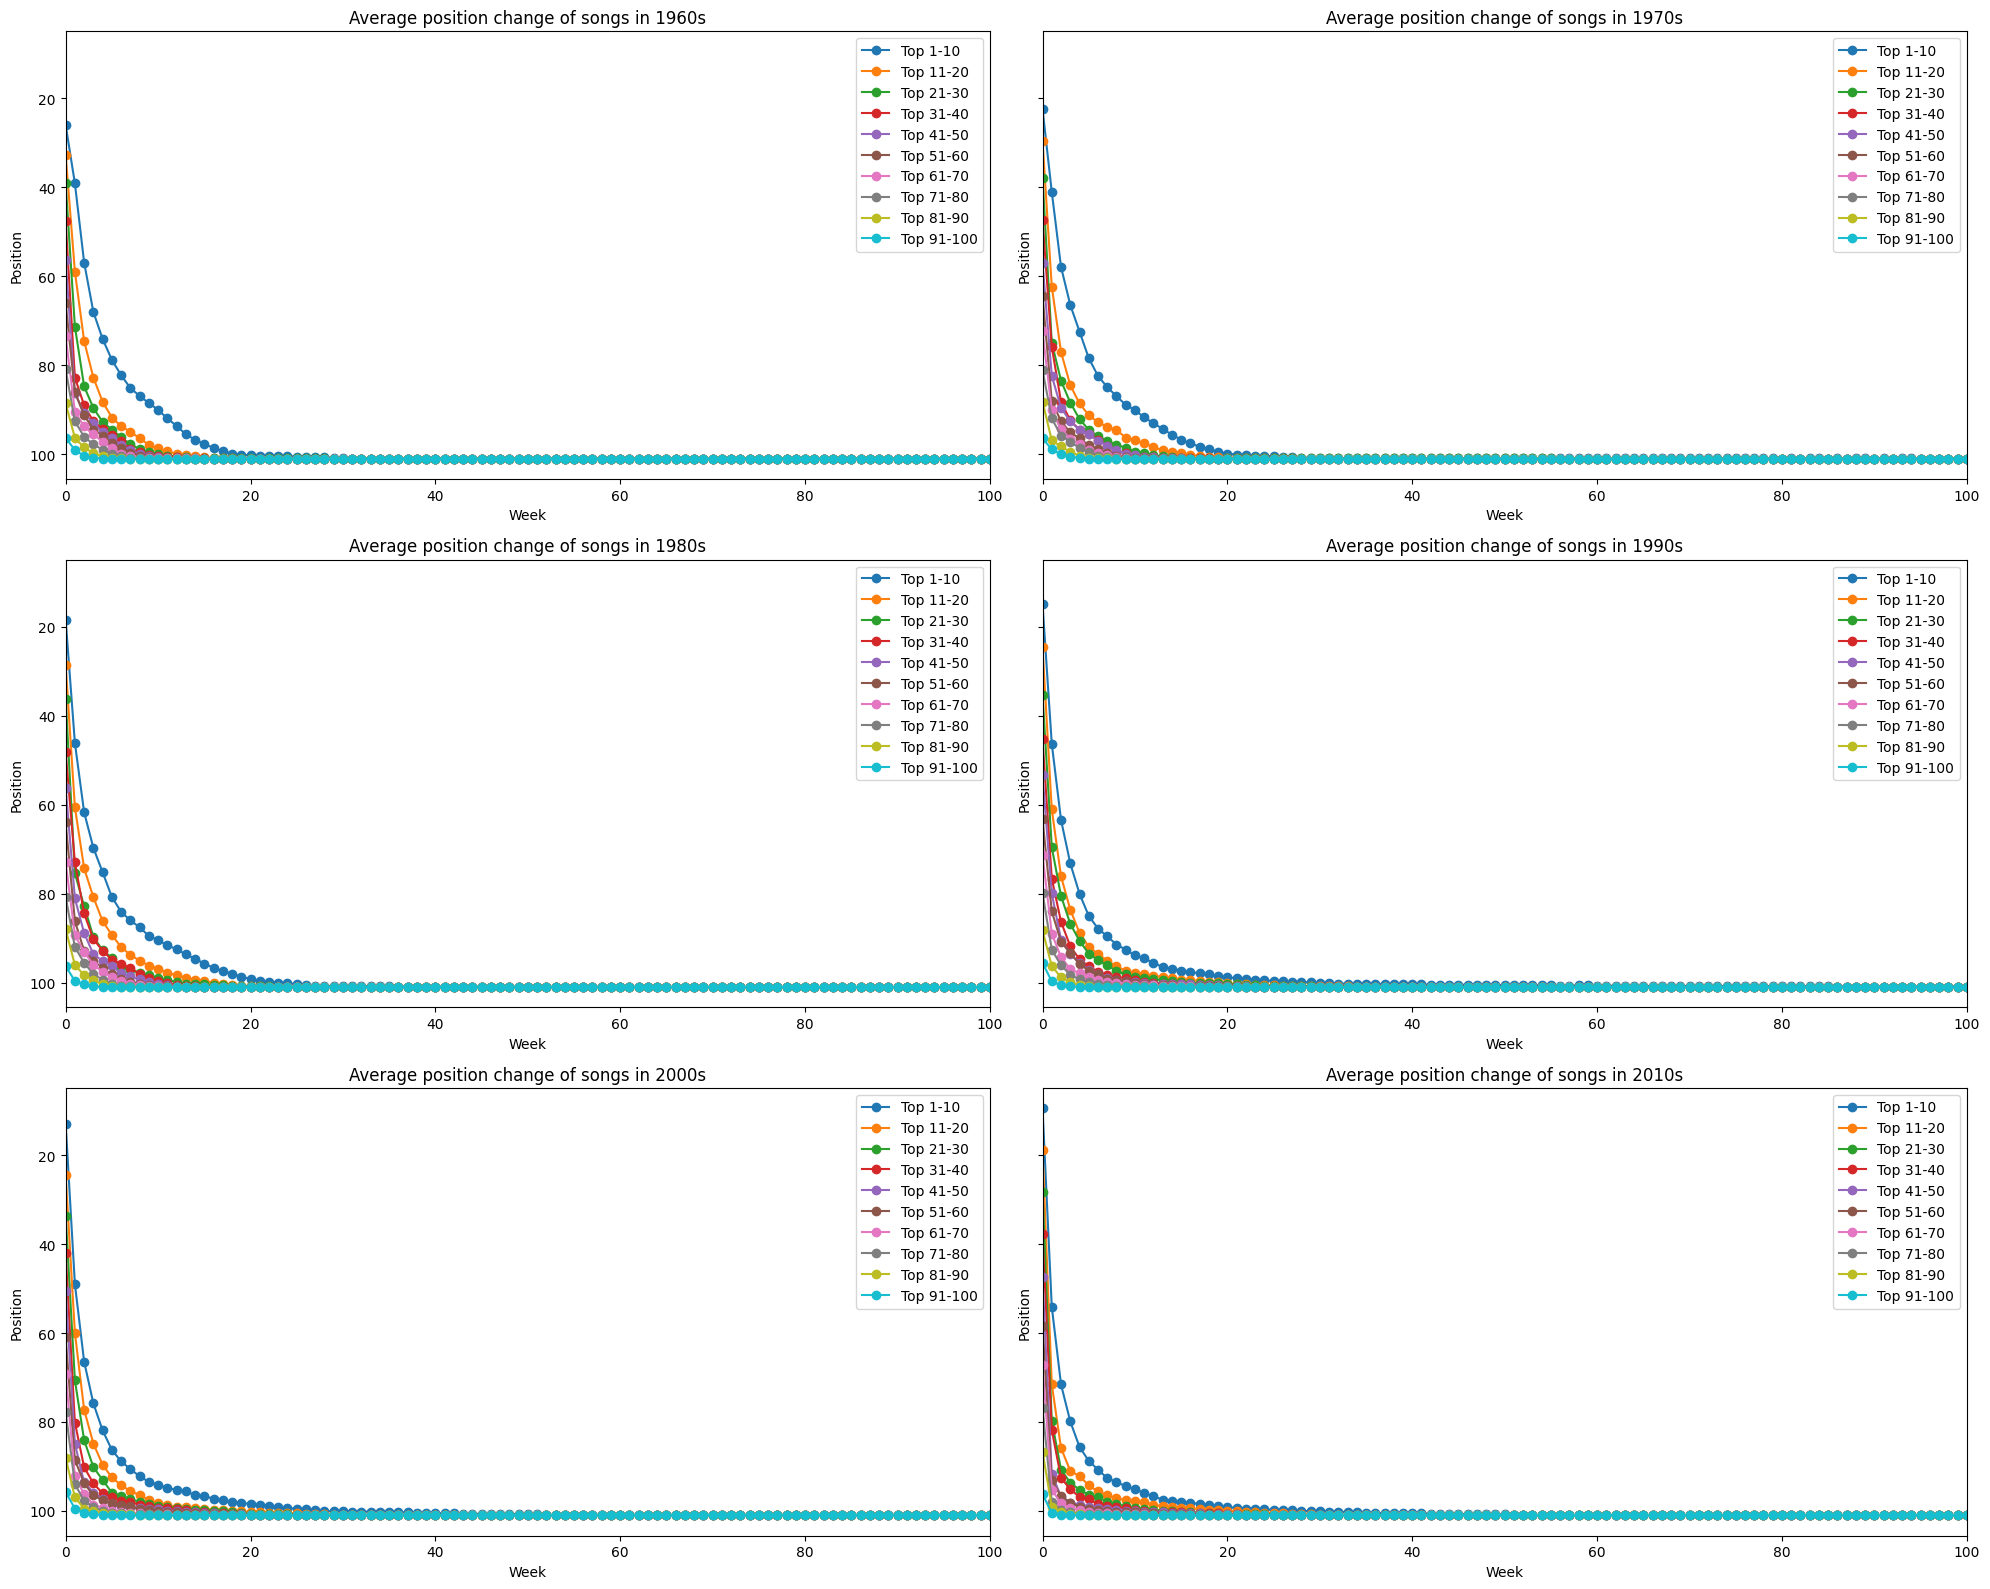

In [46]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16), sharey=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # all songs in the decade
    all_songs_in_decade = own_chart_with_empty_weeks[(own_chart_with_empty_weeks["year"] >= year) &\
        (own_chart_with_empty_weeks["year"] < year + 10)][["song_id", "first_day_of_the_week", "top_position", "position",
            "first_week"]]

    # songs from other decades
    songs_from_other_decades = own_chart[(own_chart["year"] < year) |\
        (own_chart["year"] >= year + 10)][["song_id"]]

    for top_position in range(10, 110, 10):
        # songs that reached top 50 in the decade
        top_x_positions_in_decade = all_songs_in_decade[(all_songs_in_decade["top_position"] <= top_position) &\
            (all_songs_in_decade["top_position"] > top_position - 10)][["song_id"]]

        # take songs only from this decade
        top_x_positions_in_decade = top_x_positions_in_decade[~top_x_positions_in_decade["song_id"].isin(songs_from_other_decades["song_id"])]

        # take all positions of the songs
        top_x_positions_in_decade = top_x_positions_in_decade[["song_id"]].drop_duplicates().merge(
            own_chart_with_empty_weeks[["song_id",
                "position", "first_day_of_the_week", "first_week"]], on=["song_id"], how="left")

        min_first_week = top_x_positions_in_decade["first_day_of_the_week"].min().to_pydatetime()

        top_x_positions_in_decade["first_day_of_the_week"] = top_x_positions_in_decade.apply(lambda row:
            int(((min_first_week + timedelta(
                    days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

        top_x_positions_in_decade.set_index("first_day_of_the_week", inplace=True)

        axes[row_i, col_i].plot(top_x_positions_in_decade.groupby("first_day_of_the_week")["position"].mean(),
            marker='o', label=f"Top {top_position - 9}-{top_position}")

    axes[row_i, col_i].set_title(f"Average position change of songs in {year}s")
    axes[row_i, col_i].set_xlabel("Week")
    axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].set_xlim(0, 100)
    axes[row_i, col_i].legend()

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.show()